![arc-logo](admin/image/arc-logo.png)
# Projet P3
## MarketMachineLearningModel
Ce notebook contient les différentes étapes pour la réalisation de modèle de machine learning avec le jeu de données des tweets financiers.

`Auteur` : Romain Capocasale (INF3dlm-a)

`Superviseur` : Hatem Ghorbel

`Date` : 24.01.2020

# 1. Importation

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import sys
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from gensim.sklearn_api import D2VTransformer
from gensim.utils import simple_preprocess
from joblib import dump, load
import seaborn as sns
import random
import pickle

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVR, LinearSVR, LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

np.random.seed(42)# to make this notebook's output stable across runs

# 2. Chragement du jeu de données

In [2]:
dataset = pd.read_csv('dataset/market_dataset/market.csv')

# 3. Analyse du jeu de données

In [3]:
dataset.head()

,title,sentiment
0,putting apple's record-breaking quarter into c...,0.0
1,"""@wsj: apple plans to start shipping apple wat...",-1.0
2,nike has tested the $92 level 3 times this yea...,1.0
3,"""@howardlindzon: me too (long) @sexonthebeach:...",0.0
4,@3score66 $c,0.0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225718 entries, 0 to 1225717
Data columns (total 2 columns):
title        1225718 non-null object
sentiment    1225718 non-null float64
dtypes: float64(1), object(1)
memory usage: 18.7+ MB


In [5]:
dataset.describe()

,sentiment
count,1.225718e+06
mean,6.178567e-02
std,6.167171e-01
min,-1.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,3.333333e-01
max,1.000000e+00


Le jeu de données contient 2 colonnes :
    - sentiment : le sentiment de la pharse, -1 pour negatif et 1 pour positif
    - title : la phrase en question

## 3.1 Répartition des classes

In [6]:
nb_pos, nb_neg, nb_ntr = len([sent for sent in dataset.sentiment if sent > 0]), len([sent for sent in dataset.sentiment if sent < 0]), len([sent for sent in dataset.sentiment if sent == 0])
tot = len(dataset)
print("Number of data : {}".format(tot))
print("Number of positive data : {} ({}%)".format(nb_pos, round( nb_pos/tot*100, 3)))
print("Number of negative data : {} ({}%)".format(nb_neg, round( nb_neg/tot*100, 3)))
print("Number of neutral data : {} ({}%)".format(nb_ntr, round( nb_ntr/tot*100, 3)))
print("Ratio positive/negative : {}".format(round(nb_pos/nb_neg, 3)))

Number of data : 1225718
Number of positive data : 315852 (25.769%)
Number of negative data : 238591 (19.465%)
Number of neutral data : 671275 (54.766%)
Ratio positive/negative : 1.324


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ADFF497FC8>]],
      dtype=object)

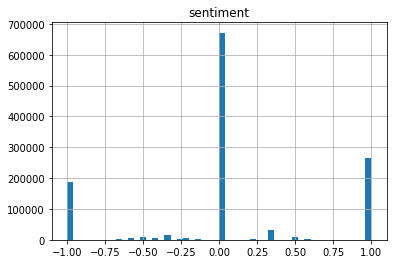

In [7]:
dataset.hist(bins=50)

On remarque qu'il y a beaucoup trop de phrases avec un setiment égal à 0. Sinon on remarque que les phrases sont en général sois totalement positive sois totalement néagative.

## 3.2 Nombre de mot moyen par phrase

In [8]:
def average_word_by_sentence(sentences):
    nb_total_word = 0
    for row in sentences:
        nb_total_word += len(row.split())
    return round(nb_total_word / len(sentences), 3)

In [9]:
print("Average of word by sentence : {}".format(average_word_by_sentence(dataset['title'])) )

Average of word by sentence : 13.487


Text(0, 0.5, 'Number of sentence')

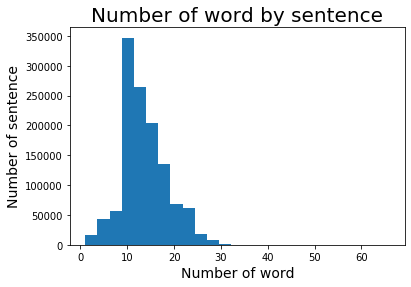

In [10]:
num_word_by_sentence = [len(x.split()) for x in dataset['title']]#count the number of word for each sentences

plt.hist(num_word_by_sentence, bins=25)
plt.title('Number of word by sentence', fontsize=20)
plt.xlabel('Number of word', fontsize=14)
plt.ylabel('Number of sentence', fontsize=14)

On remarque que la moyenne de nombre de mot par phrase est de **13** et on peut voir sur le graphe la répartirion du nombre de mot par phrase.

# 4. Reduction de la taille du jeu de données
* Suppresion de 3/4 des phrases qui ont une polarité de 0. Cela corresponds à un peu près 500'000 phrases
* On garde seulement 30'000 phrases sur les plus de 700'000 phrases restantes. Car sinon l'entrainement des modéles prends beaucoup trop de temps.

In [11]:
row_to_remove = []
for i, row in dataset.iterrows():
    if row['sentiment'] == 0:
        rand = random.randint(0,3)
        if  rand == 0 or rand == 1 or rand == 2:
            row_to_remove.append(i)

In [13]:
dataset = dataset.drop(row_to_remove)

In [15]:
dataset = dataset[0:30000]

# 5. Séparation des observation et des étiquettes

In [17]:
X = dataset['title']
y = dataset['sentiment']

## 5.1 Séparation du jeu d'entrainement et jeu de test 
Le jeu d'entrainement est séparé en 2 parties, La première partie est le jeu d'entrainement qui sera utilisé pour la création du modèle d'analyse de sentiment. Le jeu de test sera lui utilisé pour tester la qualité des modèles évalués.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# 6. Definition des méthode de calcul de score
La méthode print_scores() permet de calculer la RMSE, la MAE et la précision à partir des vrai étiquettes et des étiquettes prédites. Il est également possible d'indiquer le seuil désiré, le seuil permet de definir pour une prédiction si elle doit considéré come positive ou négative. La méthode regression_score_to_classification() permet de transformer les étiquettes du format régression au format classification. Les étiquettes de -1 à seuil sont mise à 0 et celles de seuil à 1 sont mise à 1.

In [19]:
def remove_near_zero_values(y_test, y_pred, threshold):
    '''As the classifier is here binary, on only keep the values between -1 and 0 not included and between 1 and 0 not included. 
    You must therefore delete the values at zero.Put in a list the indices of the values which are 0 and remove them from the 2 lists.
        
    y_test -- list of real value
    y_pred -- list of predicted value
    thrshold -- seuil
    
    return -- a tuple which contain y_test and y_pred without 0 values
    '''
    index_to_remove = []
    i = 0
    for test, pred in zip(y_test, y_pred):
        if test == threshold or pred == threshold:
            index_to_remove.append(i)
        i+=1
    y_test = [i for j, i in enumerate(y_test) if j not in index_to_remove]
    y_pred = [i for j, i in enumerate(y_pred) if j not in index_to_remove]
    return (y_test, y_pred)

def regression_score_to_classification(labels, threshold, offset=0.1):
    '''Set to 0 regression prediction between -1 and thresold, set to 1 regression preiction between thresold and 1
    Allow to pass from regression prediction to classification prediction
    
    labels -- list of regression score
    thresold -- thresold
    
    return -- list of labels either 0 or 1
    '''
    
    y_clf = []
    for i, y in enumerate(labels):
        if y <= threshold:
            y_clf.append(0)
        elif y > threshold:
            y_clf.append(1)
    return np.array(y_clf)
        

def print_scores(name, y_test, y_pred, threshold=0, show_classification_report=False):
    '''Display the RMSE, MAE and accuracy for a model
    
    name -- name of the model
    y_test -- true data
    y_pred -- predicted data 
    threshold=0 -- threshold
    show_classification_report=False -- display the score with sklearn.metrics.classification_report function
    
    '''
    print("RMSE for {} : {}".format(name, np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    print("MAE for {} : {}".format(name, metrics.mean_absolute_error(y_test, y_pred)))
    
    y_test, y_pred = remove_near_zero_values(y_test, y_pred, threshold)
    
    y_test_clf = regression_score_to_classification(y_test, threshold)
    y_pred_clf = regression_score_to_classification(y_pred, threshold)
    
    print("Accuracy for {} : {}".format(name, metrics.accuracy_score(y_test_clf, y_pred_clf)))
    print("Recall for {} : {}".format(name, metrics.recall_score(y_test_clf, y_pred_clf)))
    print("Precision for {} : {}".format(name, metrics.precision_score(y_test_clf, y_pred_clf)))
    if show_classification_report:
        print(metrics.classification_report(y_test_clf, y_pred_clf))

On constate que la RMSE et la MAE des deux modèles est extrement élevé. Si les modèles ont une si bonne précision et rappel parqu'il prédise enormement de fois la polarité 0. Comme les phrases avec une polarité de 0 sont retirées de pour le calcul de la précision et du rappel, ceci explique ces bons résultats. Ces 2 analyseurs fournissent donc de mauvais résultats.

# 7. Traitement du texte
Utilisations de la librairie de Gensim pour le prétraitement, car elle est effectue le processus de manière très rapide.

In [22]:
X_train_pre_gen = [' '.join(simple_preprocess(sentence)) for sentence in X_train ]
X_test_pre_gen = [' '.join(simple_preprocess(sentence)) for sentence in X_test ]

# 8. Modèle de machine learning avec TFidf

## 8.1 Création des pipelines et entrainement des modeles
Un pipeline est créé pour chaque type de modèle. Trois types de modèles ont été selectionné : 

* la régression linéaire
* la machine à vecteur de support 
* la foret aléatoire

Les différents pipelines sont entrainés avec les données d'entrainements.

In [23]:
lr_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr', LinearRegression(n_jobs=-1))])

svr_model = Pipeline([('tfidf', TfidfVectorizer()),
                      ('svr', LinearSVR())])

rfr_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('rfr', RandomForestRegressor(n_jobs=-1))])

lr_model.fit(X_train_pre_gen, y_train)
print("lr_model is done")
svr_model.fit(X_train_pre_gen, y_train)
print("svr_model is done")
rfr_model.fit(X_train_pre_gen, y_train)
print("rfr_model is done")

lr_model is done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


svr_model is done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


rfr_model is done


## 8.2 Evaluation des modèles
On peut constater que pour la plupart des modèles la précision et le rappel ont de très bon score.

In [24]:
y_pred_lr = lr_model.predict(X_test_pre_gen)
print_scores('Linear regression', y_test, y_pred_lr)
print("\n")
y_pred_svr = svr_model.predict(X_test_pre_gen)
print_scores('Support Vector Regression', y_test, y_pred_svr)
print("\n")
y_pred_rfr = rfr_model.predict(X_test_pre_gen)
print_scores('Random forest regressor', y_test, y_pred_rfr)

RMSE for Linear regression : 1.1234457925873966
MAE for Linear regression : 0.5496935634089174
Accuracy for Linear regression : 0.8714307071311108
Recall for Linear regression : 0.8693967902600996
Precision for Linear regression : 0.8900849858356941


RMSE for Support Vector Regression : 0.35365356237967693
MAE for Support Vector Regression : 0.20125624245867163
Accuracy for Support Vector Regression : 0.9455822992973538
Recall for Support Vector Regression : 0.966519092418373
Precision for Support Vector Regression : 0.9349571734475375


RMSE for Random forest regressor : 0.34003774770270523
MAE for Random forest regressor : 0.14773558922558924
Accuracy for Random forest regressor : 0.9381146920865486
Recall for Random forest regressor : 0.9527537042214146
Precision for Random forest regressor : 0.9342105263157895


## 8.3 Entrainement par validation croisée

In [25]:
scores = cross_val_score(rfr_model, X_train_pre_gen, y_train, scoring="neg_mean_absolute_error", cv=10, n_jobs=-1)
print(-scores)

[0.15647423 0.15489262 0.14589767 0.14863793 0.17140489 0.14849786
 0.15771359 0.15159185 0.15733019 0.15047917]


## 8.4 Sauvegarde du modèle

In [26]:
dump(rfr_model, 'saved_model/market_dataset_tfidf.joblib')

['saved_model/market_dataset_tfidf.joblib']

# 9. Modèle de machine learning avec w2v

## 9.1 Prétraitement du texte

In [27]:
X_train_pre_list = []
for sentence in X_train:
    X_train_pre_list.append(simple_preprocess(sentence))
    
X_test_pre_list = []
for sentence in X_test:
    X_test_pre_list.append(simple_preprocess(sentence))

## 9.2 Création du word2vec

In [28]:
doc2Vec_model =  D2VTransformer()
doc2Vec_model.fit(X_train_pre_list+X_test_pre_list)

D2VTransformer(alpha=0.025, batch_words=10000, cbow_mean=1, comment=None,
               dbow_words=0, dm=1, dm_concat=0, dm_mean=None, dm_tag_count=1,
               docvecs=None, docvecs_mapfile=None,
               hashfxn=<built-in function hash>, hs=0, iter=5,
               max_vocab_size=None, min_alpha=0.0001, min_count=5, negative=5,
               sample=0.001, seed=1, size=100, sorted_vocab=1, trim_rule=None,
               window=5, workers=3)

In [29]:
X_train_pre_d2v = doc2Vec_model.transform(X_train_pre_list)
X_test_pre_d2v = doc2Vec_model.transform(X_test_pre_list)

## 9.3 Création des pipelines et entrainement des modèles

In [30]:
rfr_model_d2v = RandomForestRegressor()
rfr_model_d2v.fit(X_train_pre_d2v, y_train)

lr_model_d2v = LinearRegression()
lr_model_d2v.fit(X_train_pre_d2v, y_train)

svr_model_d2v = LinearSVR()
svr_model_d2v.fit(X_train_pre_d2v, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [31]:
rfr_pipeline_d2v = Pipeline([('d2v', doc2Vec_model),
                     ('rfr', rfr_model_d2v)])

lr_pipeline_d2v = Pipeline([('d2v', doc2Vec_model),
                     ('rfr', lr_model_d2v)])

svr_pipeline_d2v = Pipeline([('d2v', doc2Vec_model),
                    ('svr', svr_model_d2v)])

## 9.4 Évaluation des modèles
On voit que les scores se dégrade fortement avec le word2vec.

In [32]:
y_pred_rfr_d2v = rfr_pipeline_d2v.predict(X_test_pre_list)
print_scores('Random forest regressor', y_test, y_pred_rfr_d2v)
print("\n")
y_pred_lr_d2v = lr_pipeline_d2v.predict(X_test_pre_list)
print_scores('Linear regression', y_test, y_pred_lr_d2v)
print("\n")
y_pred_svr_d2v = svr_pipeline_d2v.predict(X_test_pre_list)
print_scores('Support Vector Regression', y_test, y_pred_svr_d2v)

RMSE for Random forest regressor : 0.7477980671262645
MAE for Random forest regressor : 0.6291758698092031
Accuracy for Random forest regressor : 0.648532349777163
Recall for Random forest regressor : 0.6876595744680851
Precision for Random forest regressor : 0.6714681440443213


RMSE for Linear regression : 0.7444130997181775
MAE for Linear regression : 0.6302348712351742
Accuracy for Linear regression : 0.6639258484078338
Recall for Linear regression : 0.7116768123962368
Precision for Linear regression : 0.6807834833245103


RMSE for Support Vector Regression : 0.7516596726082497
MAE for Support Vector Regression : 0.6347387377435706
Accuracy for Support Vector Regression : 0.6518164150097174
Recall for Support Vector Regression : 0.7396236856668511
Precision for Support Vector Regression : 0.6582122629894115


## 9.5 Entrainement pas validation croisée

In [33]:
scores = cross_val_score(rfr_model, X_train_pre_gen, y_train, scoring="neg_mean_absolute_error", cv=10, n_jobs=-1)
print(-scores)

[0.16142867 0.16551118 0.14766937 0.14727569 0.15931616 0.14829028
 0.15782019 0.14835045 0.16264062 0.15791414]


## 9.6 Représentation T-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.100s...
[t-SNE] Computed neighbors for 10000 samples in 30.985s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.040622
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.147148
[t-SNE] KL divergence after 1000 iterations: 3.000699


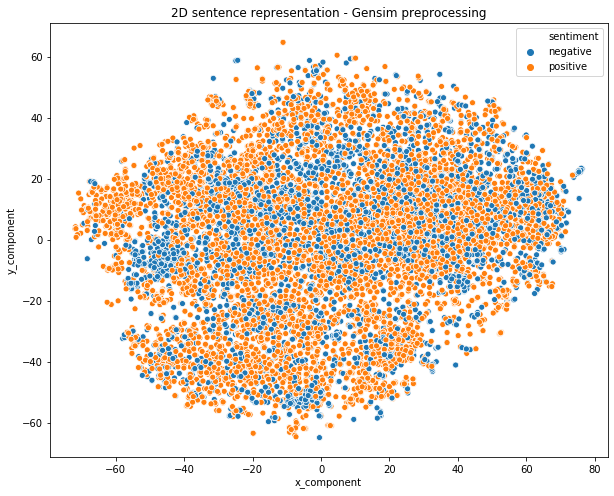

In [34]:
tsne = TSNE(n_components=2, random_state=0, verbose=1)
X_2d_gen = tsne.fit_transform(X_train_pre_d2v[0:10000])

X_component_gen = [item[0] for item in X_2d_gen]
Y_component_gen = [item[1] for item in X_2d_gen]

sent = ["positive" if sent>= 0 else "negative" for sent in (y_train.tolist()[0:10000])]

df_scatter_gen = pd.DataFrame({'x_component':X_component_gen, 'y_component':Y_component_gen, 'sentiment':sent})
plt.figure(figsize=(10,8))
plt.title("2D sentence representation - Gensim preprocessing")
ax = sns.scatterplot(x='x_component', y='y_component', hue='sentiment', data=df_scatter_gen)

# 9.7 Sauvegarde du modèle

In [35]:
dump(rfr_pipeline_d2v, 'saved_model/market_dataset_w2v.joblib')

['saved_model/market_dataset_w2v.joblib']

# 10. word2vec financier 
## 10.1 Importation du word2vec financier

In [36]:
sys.path.insert(0, 'word2vec/financialWord2vec/src')
from financial_corpus import FinancialCorpus
from financial_w2vec import FinancialWord2Vec

financial_w2vec = pickle.load(open('word2vec/financialWord2vec/data/models_pickle/FinancialWord2Vec.pkl','rb'))
w2vec_model = financial_w2vec.model
financial_corpus = financial_w2vec.financial_corpus

bigram_mod = financial_corpus.bigram_mod
trigram_mod = financial_corpus.bigram_mod

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romain.capocasa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 10.2 Longeur maximum d'une phrase

In [37]:
max_sentence_length = 0
for sentence in dataset["title"]:
    sentence_length = len(sentence.split())
    if sentence_length > max_sentence_length:
        max_sentence_length = sentence_length
print("The maximum word in a sentence is : {}".format(max_sentence_length))

The maximum word in a sentence is : 41


## 10.3 Calcul du Tf-idf
Le score TF-idf est calculé sur le jeu de donnée et les scores sont exporté dans un dictionnaire avec comme clé le mot et comme valeur le score TF-idf de ce mot.

In [38]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(X_train_pre_gen+X_test_pre_gen)

feature_names = tfidf.get_feature_names()
word2tfidf = dict(zip(feature_names, tfidf.idf_))

## 10.4 Définition des fonctions
Definitions des différentes fonctions permettant de représenter une phrase dans l'espace.

In [39]:
def get_tfidf_score(word):
    '''Return the TF-idf score for a word. If the word is not in the dict return 0.
    
    word -- a word of a sentence
    
    return -- the TF-idf score for this word
    '''
    if word in word2tfidf:
        return word2tfidf[word]
    else:
        return 0.0

In [40]:
def get_w2v_from_word(word, dimension=100):
    '''Return the word2vec vector for the given word. 
    If the word is not in the word2vec vocab return a fille vector of 0 the size of the dimension
    
    word -- a word of a sentence
    dimension -- the dimension of the vector
    
    return -- The word2vec vector
    '''
    if word in w2vec_model.wv.vocab: 
        doc = trigram_mod[bigram_mod[[word]]]
        return w2vec_model.wv[doc][0]
    else :
        return np.zeros(dimension)

In [41]:
def sentences_to_w2v_big_vector(sentences, mode, dimesion=100):
    '''Transforms the list of passed sentences into a vector representation. The vectors here are concatenate.
    For exemple : if the maximum sentence size is 25 and the dimension is 100. The number of vector component will be 2500.
    
    sentences -- list of preprocessed sentences
    mode -- type of vectorial representation, 'concat' => concatene all the word vector in sequence,'concat_tfidf' => concatene the word vector and multiply by the tf-idf score of the word, 
    dimension -- the dimension of the vector

    return -- the list of sentences in the space
    '''
    sentences_w2v = []
    for sentence in sentences:  
        
        vectors = np.asarray([])
        splited_sentence = sentence.split()
        for i in range(0, max_sentence_length):
            try :
                word = splited_sentence[i]
                w2v_word = get_w2v_from_word(word)
                
                if mode=="concat_tfidf":
                    tfidf_score = get_tfidf_score(word)
                    vectors = np.append(vectors, w2v_word*tfidf_score)
                elif mode=="concat":
                    vectors = np.append(vectors, w2v_word)
                
            except IndexError:
                vectors = np.append(vectors, np.zeros(dimension))
                
        sentences_w2v.append(vectors)
    return sentences_w2v

In [42]:
def sentences_to_w2v_small_vector(sentences, mode, dimension=100):
    '''Transforms the list of passed sentences into a vector representation. The vector is summed.
    For exemple : if the maximum sentence size is 25 and the dimension is 100. The number of vector component will be 100.
    
    sentences - list of preprocessed sentences
    mode -- type of vectorial representation, 'sum' => sum all the vector, 'sum_tfidf' => sum the vector and multiply each vector by tf_idf score, 'avg' => sum all the vector and divide by the sentence length, 'avg' => sum the vector, multiply each vector by tf_idf score and divide by sentence length
    dimension -- the dimension of the vector
    
    return the list of sentences in the space
    '''
    sentences_w2v = []    
    for sentence in sentences:
        vectors = np.zeros(100)
        
        splited_sentence = sentence.split()
        for word in splited_sentence:
            w2v_word = get_w2v_from_word(word)
            
            if mode=="sum_tfidf" or mode=="avg_tfidf":
                tfidf_score=get_tfidf_score(word)
                vectors = np.add(vectors, w2v_word*tfidf_score)
            elif mode=="sum" or mode=="avg":              
                vectors = np.add(vectors, w2v_word)
        
        if mode=="avg_tfidf" or mode=="avg":    
            if len(splited_sentence) != 0:
                sentences_w2v.append(vectors/len(splited_sentence))
            else :
                sentences_w2v.append(np.zeros(dimension))
        elif mode=="sum" or mode=="sum_tfidf":
            sentences_w2v.append(vectors)
    return np.asarray(sentences_w2v)

## 10.5 Représentation des phrases dans l'espace

In [43]:
X_train_pre_w2v = sentences_to_w2v_small_vector(X_train_pre_gen, mode="avg")
X_test_pre_w2v = sentences_to_w2v_small_vector(X_test_pre_gen, mode="avg")

## 10.6 Entrainement des modèles

In [44]:
rfr_model_w2v = RandomForestRegressor()
rfr_model_w2v.fit(X_train_pre_w2v, y_train)
print("training finish for rfr")

lr_model_w2v = LinearRegression()
lr_model_w2v.fit(X_train_pre_w2v, y_train)
print("training finish for lr")

svr_model_w2v = LinearSVR()
svr_model_w2v.fit(X_train_pre_w2v, y_train)
print("training finish for svr")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


training finish for rfr
training finish for lr


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


training finish for svr


## 10.7 Calcul des scores
On remarque cette fois ci que la précison et le rappel augmente par rapport à Gensim. Cependant, la rmse et la mae n'ont pas un bon scrore

In [45]:
y_pred_rfr_w2v = rfr_model_w2v.predict(X_test_pre_w2v)
print_scores('Random forest regressor', y_test, y_pred_rfr_w2v)
print("\n")
y_pred_lr_w2v = lr_model_w2v.predict(X_test_pre_w2v)
print_scores('Linear regression', y_test, y_pred_lr_w2v)
print("\n")
y_pred_svr_w2v = svr_model_w2v.predict(X_test_pre_w2v)
print_scores('Support Vector Regression', y_test, y_pred_svr_w2v)

RMSE for Random forest regressor : 0.566859219486701
MAE for Random forest regressor : 0.4218054279933531
Accuracy for Random forest regressor : 0.827033565164802
Recall for Random forest regressor : 0.8735664335664336
Precision for Random forest regressor : 0.818610747051114


RMSE for Linear regression : 0.6280005624577554
MAE for Linear regression : 0.5050993800499307
Accuracy for Linear regression : 0.7945881297652863
Recall for Linear regression : 0.811289429994466
Precision for Linear regression : 0.8090507726269316


RMSE for Support Vector Regression : 0.6485717598522014
MAE for Support Vector Regression : 0.49415956829217206
Accuracy for Support Vector Regression : 0.7877111675885783
Recall for Support Vector Regression : 0.798284449363586
Precision for Support Vector Regression : 0.8067673378076062


## 10.8 Entrainement par validation croisée

In [46]:
scores = cross_val_score(rfr_model_w2v, X_train_pre_w2v, y_train, scoring="neg_mean_absolute_error", cv=10, n_jobs=-1)
print(-scores)

[0.430994   0.42516404 0.43812195 0.41529399 0.42920264 0.41790384
 0.43377031 0.41908985 0.4455897  0.41516811]


## 10.9 T-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.104s...
[t-SNE] Computed neighbors for 10000 samples in 30.487s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.171799
[t-SNE] KL divergence after 1000 iterations: 1.833750


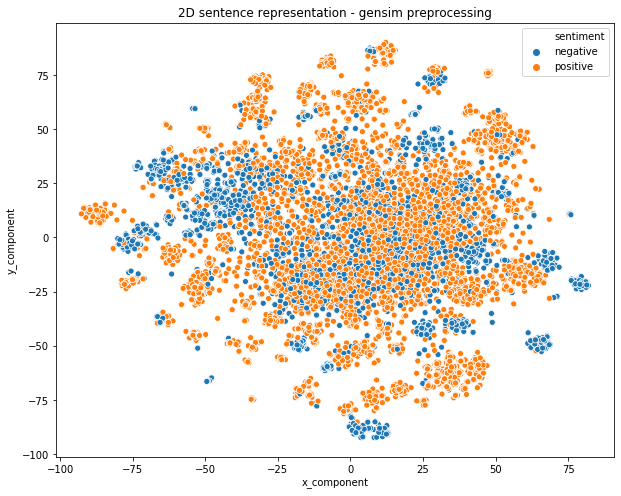

In [47]:
X_2d_financial = tsne.fit_transform(X_train_pre_w2v[0:10000])
X_component_financial = [item[0] for item in X_2d_financial]
Y_component_financial = [item[1] for item in X_2d_financial]
df_scatter_financial = pd.DataFrame({'x_component':X_component_financial, 'y_component':Y_component_financial, 'sentiment':sent})
plt.figure(figsize=(10,8))
plt.title("2D sentence representation - gensim preprocessing")
ax = sns.scatterplot(x='x_component', y='y_component', hue='sentiment', data=df_scatter_financial)

# 11. Classificateur

In [48]:
classfication_data = pd.read_csv('dataset/market_dataset/market.csv')

## 11.1 Prétraitement des données
On enlève les phrases avec un sentiment compris entre -0.3 et 0.3

In [49]:
print("size before : {}".format(len(classfication_data)))
index_to_remove = []
for i, e in classfication_data.iterrows():
    if e['sentiment'] < 0.3 and e['sentiment'] > -0.3:
        index_to_remove.append(i)


size before : 1225718


In [50]:
classfication_data = classfication_data.drop(index_to_remove)
print("size after : {}".format(len(classfication_data)))

size after : 540779


In [51]:
classfication_data = classfication_data[0:30000]

## 11.2 Séparation des données
le sentiment est défini à 0 pour une phrase négative et 1 pour une phrase positive

In [52]:
X_classification = classfication_data['title']
y_classfication = np.array([1 if s > 0 else 0 for s in classfication_data['sentiment']])
X_train_classification, X_test_classification, y_train_classfication, y_test_classification = train_test_split(X_classification, y_classfication, test_size=0.30, random_state=42)

## 11.3 Prétraitement du texte

In [53]:
X_train_pre_gen_classification = [' '.join(simple_preprocess(sentence)) for sentence in X_train_classification]
X_test_pre_gen_classification = [' '.join(simple_preprocess(sentence)) for sentence in X_test_classification ]

## 11.4 Entrainement des modèles

In [54]:
nb_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('nb', MultinomialNB())])

svc_model = Pipeline([('tfidf', TfidfVectorizer()),
                     ('svc', LinearSVC())])

dtc_model = Pipeline([('tfidf', TfidfVectorizer()),
                     ('dtc', DecisionTreeClassifier())])

logr_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr', LogisticRegression())])

nb_model.fit(X_train_pre_gen_classification, y_train_classfication)
svc_model.fit(X_train_pre_gen_classification, y_train_classfication)
dtc_model.fit(X_train_pre_gen_classification, y_train_classfication)
logr_model.fit(X_train_pre_gen_classification, y_train_classfication)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

## 11.5 Calcul des scores
On constate que le modèle SVC et Regression Logistic obtient d'excellent résultats

In [55]:
y_pred_nb = nb_model.predict(X_test_pre_gen_classification)
print("Accuracy for Naive Bayes : {}".format(metrics.accuracy_score(y_test_classification, y_pred_nb)))
print("Recall for Naive Bayes : {}".format(metrics.recall_score(y_test_classification, y_pred_nb)))
print("Precision for Naive Bayes : {}".format(metrics.precision_score(y_test_classification, y_pred_nb)))
print("\n")

y_pred_svc = svc_model.predict(X_test_pre_gen_classification)
print("Accuracy for SVC : {}".format(metrics.accuracy_score(y_test_classification, y_pred_svc)))
print("Recall for SVC : {}".format(metrics.recall_score(y_test_classification, y_pred_svc)))
print("Precision for SVC : {}".format(metrics.precision_score(y_test_classification, y_pred_svc)))
print("\n")

y_pred_dtc = dtc_model.predict(X_test_pre_gen_classification)
print("Accuracy for Decision Tree Classifier : {}".format(metrics.accuracy_score(y_test_classification, y_pred_dtc)))
print("Recall for Decision Tree Classifier : {}".format(metrics.recall_score(y_test_classification, y_pred_dtc)))
print("Precision for Decision Tree Classifier : {}".format(metrics.precision_score(y_test_classification, y_pred_dtc)))
print("\n")

y_pred_logr = logr_model.predict(X_test_pre_gen_classification)
print("Accuracy for Logistic Regression : {}".format(metrics.accuracy_score(y_test_classification, y_pred_logr)))
print("Recall for Logistic Regression : {}".format(metrics.recall_score(y_test_classification, y_pred_logr)))
print("Precision for Logistic Regression : {}".format(metrics.precision_score(y_test_classification, y_pred_logr)))
print("\n")

Accuracy for Naive Bayes : 0.9071111111111111
Recall for Naive Bayes : 0.9655940093098563
Precision for Naive Bayes : 0.877505977561155


Accuracy for SVC : 0.9608888888888889
Recall for SVC : 0.9757134183363692
Precision for SVC : 0.9540866811794974


Accuracy for Decision Tree Classifier : 0.897
Recall for Decision Tree Classifier : 0.9077109896782027
Precision for Decision Tree Classifier : 0.9049636803874092


Accuracy for Logistic Regression : 0.9371111111111111
Recall for Logistic Regression : 0.9694393847399312
Precision for Logistic Regression : 0.920268972142171




## 11.6 Entrainement du modèle par validation croisée

In [56]:
scores = cross_val_score(svc_model, X_train_pre_gen_classification, y_train_classfication, scoring="accuracy", cv=10, n_jobs=-1)
print(scores)

[0.95428571 0.96047619 0.96190476 0.95619048 0.96       0.96
 0.95666667 0.95904762 0.95666667 0.96952381]


# 12. Calcul des scores sur des headlines

## 12.1 Prétraitement

In [57]:
headlines = pd.read_json('dataset/headlines_dataset/financialData.json')

In [58]:
X_test_headlines = headlines['title']
y_test_headlines = np.array([1 if s > 0 else 0 for s in headlines['sentiment']])

In [59]:
X_test_pre_gen_headlines = [' '.join(simple_preprocess(sentence)) for sentence in X_test_headlines]

## 12.2 Calcul les scores
On constate malheurusement que avec les headlines les résultats obtenus sont très mauvais...

In [60]:
y_pred_svc_headlines = svc_model.predict(X_test_headlines)
print("Accuracy for SVC : {}".format(metrics.accuracy_score(y_test_headlines, y_pred_svc_headlines)))
print("Recall for SVC : {}".format(metrics.recall_score(y_test_headlines, y_pred_svc_headlines)))
print("Precision for SVC : {}".format(metrics.precision_score(y_test_headlines, y_pred_svc_headlines)))

Accuracy for SVC : 0.6161898115840894
Recall for SVC : 0.6321184510250569
Precision for SVC : 0.7097186700767263


In [61]:
y_test_regr_headlines =  headlines['sentiment']

In [62]:
y_pred_svr_headlines = svr_model.predict(X_test_pre_gen_headlines)
print_scores("SVR",y_pred_svr_headlines, y_test_regr_headlines)

RMSE for SVR : 0.688295708796332
MAE for SVR : 0.5242335821722356
Accuracy for SVR : 0.6312031417350946
Recall for SVR : 0.7230104873534855
Precision for SVR : 0.6674259681093394


In [63]:
X_test_regr_w2v = sentences_to_w2v_small_vector(X_test_pre_gen_headlines, mode="avg")

y_pred_rfr_headlines = rfr_model_w2v.predict(X_test_regr_w2v)
print_scores("Random Forest Regressor", y_pred_rfr_headlines, y_test_regr_headlines)

RMSE for Random Forest Regressor : 0.4637818824979811
MAE for Random Forest Regressor : 0.37398091976077985
Accuracy for Random Forest Regressor : 0.5719489981785064
Recall for Random Forest Regressor : 0.6591565569035239
Precision for Random Forest Regressor : 0.6610660486674391


# 13. Conclusion
On constate donc que le modèle effectue de mauvaise prédiction sur le jeu de données des headlines financières. Ces modèles sont donc à abandonner. Pour plus d'information merci de consulter le rapport.